In [153]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *

In [154]:
grid_size = 106
carrier = nrCarrierConfig(NSizeGrid = 106, SubcarrierSpacing = 15)
pci = 69
ssb_grid = np.zeros((240,4), dtype='complex')
ssb_grid[nrPSSIndices(), 0] = nrPSS(pci)
ssb_grid[nrPSSIndices(), 2] = nrSSS(pci)
ressource_grid = nrResourceGrid(carrier)
ressource_grid[ressource_grid.shape[0] // 2 - ssb_grid.shape[0] // 2 : ressource_grid.shape[0] // 2 + ssb_grid.shape[0] // 2,
               2:6] = ssb_grid

# dummy data
ressource_grid[:, 6:12] = np.ones((ressource_grid.shape[0], 6), dtype='complex')

waveform, ofdm_info = nrOFDMModulate(carrier, ressource_grid)
# plt.imshow(np.abs(ressource_grid), extent=[0,1,0,1], aspect='auto')

In [155]:
decimation_factor = 2
rx_waveform = scipy.signal.decimate(waveform, decimation_factor)
fs = ofdm_info['SampleRate'] // decimation_factor
rx_grid_size = grid_size // decimation_factor

detected NID2 is 0 at 2272


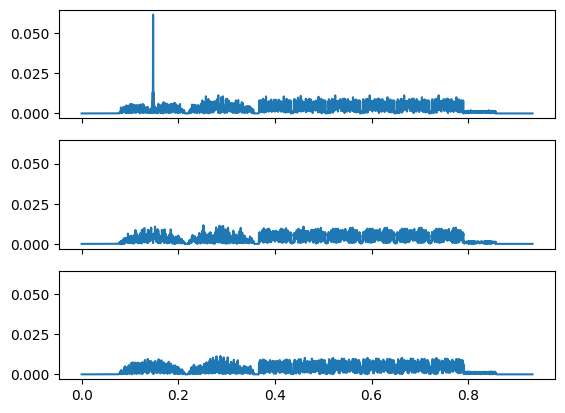

In [156]:
# detect PSS
rx_carrier = nrCarrierConfig(NSizeGrid = rx_grid_size, SubcarrierSpacing = 15)
Nfft = 1024
peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
pssIndices = np.arange((rx_carrier.NSizeGrid * 12 // 2 - 64), (rx_carrier.NSizeGrid * 12 // 2 + 63))
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    slotGrid = nrResourceGrid(rx_carrier)
    slotGrid = slotGrid[:, 0]
    slotGrid[pssIndices] = nrPSS(current_NID2)
    [refWaveform, info] = nrOFDMModulate(rx_carrier, slotGrid)
    refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

    temp = scipy.signal.correlate(rx_waveform[:int(25e-3 * fs)], refWaveform, 'valid')  # correlate over 25 ms
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/fs*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2} at {peak_index[detected_NID2]}')

In [157]:
nrbSSB = 20
refGrid = np.zeros((nrbSSB*12, 2), dtype='complex')
refGrid[nrPSSIndices(), 1] = nrPSS(detected_NID2)
timingOffset = nrTimingEstimate(waveform = rx_waveform, nrb = nrbSSB, scs = 15, initialNSlot = 0, refGrid = refGrid, SampleRate = fs)
print(timingOffset)

1096


In [158]:
# demodulate complete rx waveform
rxGrid = nrOFDMDemodulate(waveform = rx_waveform[timingOffset:], nrb = rx_grid_size, scs = 15, initialNSlot = 0, SampleRate = fs)
rxGrid /= np.max((rxGrid.real.max(), rxGrid.imag.max()))

Text(0.5, 0.95, 'SSS symbols')

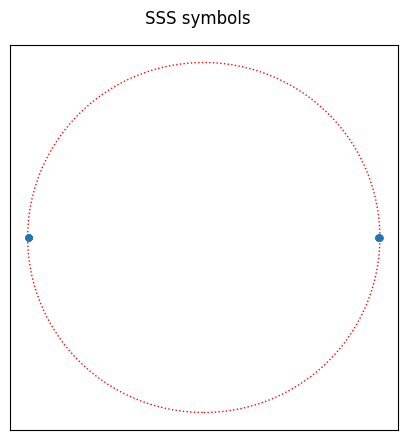

In [159]:
sssIndices = nrPSSIndices() + rxGrid.shape[0] // 2 - 120
sssRx = nrExtractResources(sssIndices, rxGrid[:, 3:])
sssRx /= np.max((sssRx.real.max(), sssRx.imag.max())) # scale sssRx symbols individually

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(sssRx.real, sssRx.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols', y=0.95)

detected NID1 is 23
detected NID is 69


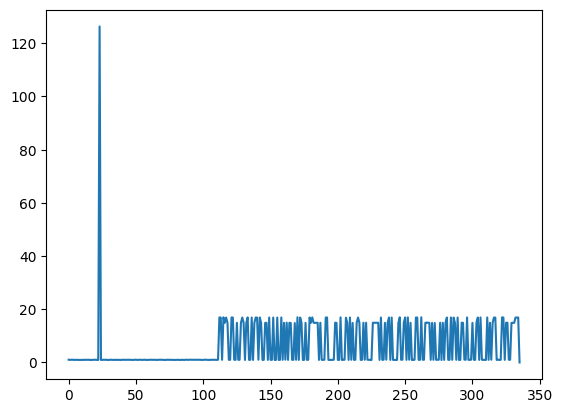

In [161]:
sssEst = np.zeros(336)
for NID1 in range(335):
    ncellid = (3*NID1) + detected_NID2
    sssRef = nrSSS(ncellid)
    sssEst[NID1] = np.abs(np.vdot(sssRx, sssRef))

detected_NID1 = np.argmax(sssEst)
detected_NID = detected_NID1*3 + detected_NID2
print(f'detected NID1 is {detected_NID1}')
print(f'detected NID is {detected_NID}')
plt.plot(sssEst)
plt.show()

Text(0.5, 0.95, 'Dummy data')

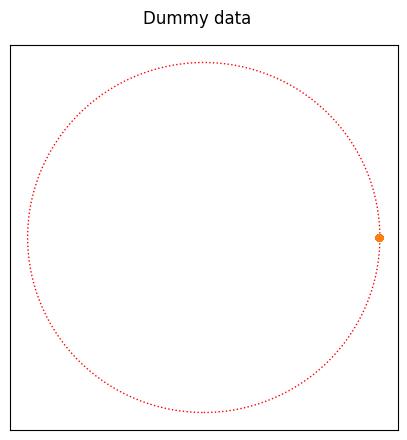

In [160]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(rxGrid[:, 8:10].real, rxGrid[:, 8:10].imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('Dummy data', y=0.95)